<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/trade_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this project we will be linking the [V-Dem dataset](https://www.v-dem.net/en) and the [CEPII Trade History dataset](http://www.cepii.fr/cepii/en/bdd_modele/bdd.asp) into a time series graph dataset, in an attempt to investigate how bilateral trade affects the democratization of nations over time.

In [0]:
dataset_path = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset')
# here we load the democracy indices from the V-Dem dataset
vdem_nodes = pd.read_csv(os.path.join(dataset_path, "V-Dem-CY-Core-v10.csv"))
vdem_nodes.head()

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,codingstart_contemp,codingend_contemp,codingstart_hist,codingend_hist,gapstart1,gapstart2,gapstart3,gapend1,gapend2,gapend3,COWcode,v2x_polyarchy,v2x_polyarchy_codelow,v2x_polyarchy_codehigh,v2x_polyarchy_sd,v2x_libdem,v2x_libdem_codelow,v2x_libdem_codehigh,v2x_libdem_sd,v2x_partipdem,v2x_partipdem_codelow,v2x_partipdem_codehigh,v2x_partipdem_sd,v2x_delibdem,v2x_delibdem_codelow,v2x_delibdem_codehigh,v2x_delibdem_sd,v2x_egaldem,v2x_egaldem_codelow,v2x_egaldem_codehigh,...,v2x_EDcomp_thick,v2x_EDcomp_thick_codelow,v2x_EDcomp_thick_codehigh,v2x_EDcomp_thick_sd,v2x_freexp,v2x_freexp_codelow,v2x_freexp_codehigh,v2x_freexp_sd,v2x_hosabort,v2x_hosinter,v2x_legabort,v2xcl_disc,v2xcl_disc_codelow,v2xcl_disc_codehigh,v2xcl_disc_sd,v2xcl_dmove,v2xcl_dmove_codelow,v2xcl_dmove_codehigh,v2xcl_dmove_sd,v2xcl_slave,v2xcl_slave_codelow,v2xcl_slave_codehigh,v2xcl_slave_sd,v2xel_elecparl,v2xel_elecpres,v2xex_elecleg,v2xlg_leginter,v2xme_altinf,v2xme_altinf_codelow,v2xme_altinf_codehigh,v2xme_altinf_sd,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.043,0.029,0.055,0.013,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [0]:
tradhist_gdppop = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GDP_POP.xlsx"))
tradhist_gdppop.head()

,iso,year,GDP,SOURCE_GDP,POP,SOURCE_POP,SOURCE_SH_PRIM,SOURCE_SH_SECD,SH_PRIM,SH_SECD
0,MMR,1827,NaN,NaN,3605.399902,MADDISON_IPO,NaN,NaN,NaN,NaN
1,SOM,1827,NaN,NaN,1077.427124,MADDISON_IPO,NaN,NaN,NaN,NaN
2,ADEN,1827,NaN,NaN,2627.580078,MADDISON_IPO,NaN,NaN,NaN,NaN
3,MOZ,1827,NaN,NaN,2319.700684,MADDISON_IPO,NaN,NaN,NaN,NaN
4,PRI,1827,NaN,NaN,305.633331,MADDISON_IPO,NaN,NaN,NaN,NaN


In [0]:
# now we load the time invariant bilateral data from the CEPII TradHist dataset
tradhist_timeinvar = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx"))
tradhist_timeinvar.head()

,iso_o,iso_d,Distw,Dist_coord,Evercol,Comlang,Contig
0,2SICIL,AUTHUN,NaN,837.066180,0,0,0
1,2SICIL,BEL,NaN,1349.682430,0,0,0
2,2SICIL,CHL,NaN,11978.672481,0,0,0
3,2SICIL,ESP,NaN,1514.852764,0,0,0
4,2SICIL,FRA,NaN,1291.794085,0,0,0


In [0]:
# then load the three files that constitute the bilateral historical non trade related data such as distances between countries and colonial status
tradhist_timevar_frames = []
for idx in range(1, 4):
    tradhist_timevar_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
tradhist_timevar = pd.concat(tradhist_timevar_frames)
tradhist_timevar.head()

,iso_o,iso_d,year,SeaDist_SHRT,SeaDist_2CST,Curcol,Metro,Colo
0,2SICIL,AUTHUN,1838,1790.884033,1790.884033,0,NaN,NaN
1,2SICIL,BEL,1834,4463.319824,4463.319824,0,NaN,NaN
2,2SICIL,BEL,1835,4463.319824,4463.319824,0,NaN,NaN
3,2SICIL,BEL,1836,4463.319824,4463.319824,0,NaN,NaN
4,2SICIL,BEL,1837,4463.319824,4463.319824,0,NaN,NaN


In [0]:
tradhist_bitrade_frames = []
for idx in range(1, 4):
    tradhist_bitrade_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))))
tradhist_bitrade = pd.concat(tradhist_bitrade_frames)
tradhist_bitrade.head()

,iso_o,iso_d,year,FLOW,FLOW_0,SOURCE_TF,BITARIFF
0,2SICIL,AUTHUN,1838,492920.687500,NaN,RIC_IP,NaN
1,2SICIL,BEL,1834,38164.500000,NaN,RIC_IP,NaN
2,2SICIL,BEL,1835,30052.339844,NaN,RIC_IP,NaN
3,2SICIL,BEL,1836,44906.539062,NaN,RIC_IP,NaN
4,2SICIL,BEL,1837,33957.269531,NaN,RIC_IP,NaN


Previous studies how shown that geographical closeness and colonizer/colony status affects the diffusion of democracy. It seems likely following from this that trade would result in some democratization diffusion effect also.

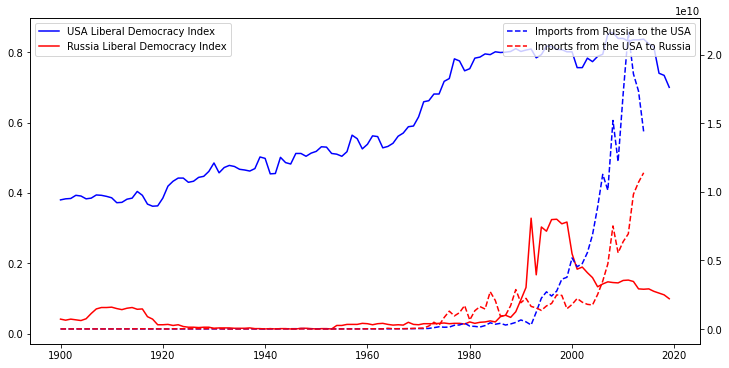

In [0]:
# TradHist dataset has data for USSR separate than from Russia
# USA : USA
# Russia: RUS, USSR (VDem uses RUS only, TradHist uses RUS and USSR)
colours = ['r', 'b']

# get high level indicators of democracy
ctry_demind = {}
ctry_demind["USA"] = vdem_nodes[(vdem_nodes['country_text_id'] == "USA") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]
ctry_demind["RUS"] = vdem_nodes[(vdem_nodes['country_text_id'] == "RUS") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]


# get imports of one country from the other
ctry_trade = {}
ctry_trade["USA"] = tradhist_bitrade[((tradhist_bitrade['iso_o'] == "RUS") | (tradhist_bitrade['iso_o'] == "USSR"))
                                     & (tradhist_bitrade['iso_d'] == "USA") 
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])
ctry_trade["RUS"] = tradhist_bitrade[(tradhist_bitrade['iso_o'] == "USA")
                                     & ((tradhist_bitrade['iso_d'] == "RUS") | (tradhist_bitrade['iso_d'] == "USSR"))
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])

# plot the data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_trade["USA"].values[:, 0], ctry_trade["USA"].values[:, 1], 'b--', label="Imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_trade["RUS"].values[:, 0], ctry_trade["RUS"].values[:, 1], 'r--', label="Imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

The figure seems to show some non-linear relationship between trade and liberal democracy index. The casuality direction of this is not clear however.

These figures show us that normalising the trade data will be important to prevent any relationships being overshadowed by GDP growth, even if GDP growth will likely be another key factor that affects democratization. We will therefore be using GDP and population as a node feature, and normalising trade data by the GDP of a country at that time.

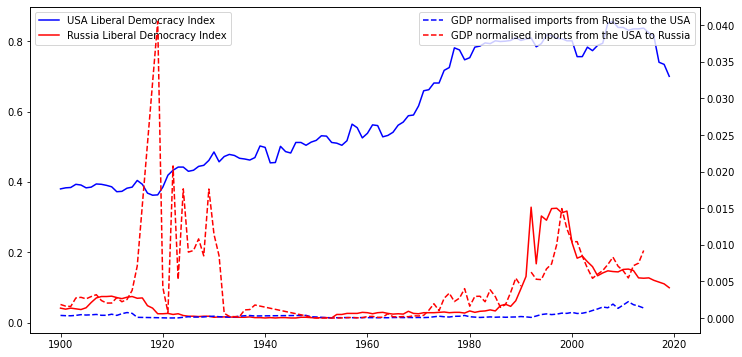

In [0]:
ctry_gdp_trade = {}
usa_gdp = tradhist_gdppop[(tradhist_gdppop['iso'] == 'USA') & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['USA'] = pd.merge(usa_gdp, ctry_trade['USA'], how='inner')
rus_gdp = tradhist_gdppop[((tradhist_gdppop['iso'] == 'RUS') | (tradhist_gdppop['iso'] == 'USSR')) & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['RUS'] = pd.merge(rus_gdp, ctry_trade['RUS'], how='inner')

# plot the data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["USA"][['year']].values[:, 0], ctry_gdp_trade["USA"][['FLOW']].values[:, 0] / ctry_gdp_trade["USA"][['GDP']].values[:, 0], 'b--', label="GDP normalised imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["RUS"][['year']].values[:, 0], ctry_gdp_trade["RUS"][['FLOW']].values[:, 0] / ctry_gdp_trade["RUS"][['GDP']].values[:, 0], 'r--', label="GDP normalised imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

This normalised data does seems to show a significant correlation between Russian imports of American goods with democratization.

We now need to find a way of linking the two datasets. The trade history dataset uses the ISO country codes. However the V-Dem dataset seems to have its own country numbering system, and the three letter shortened name isn't specified in the reference manual to be the ISO name. Lets look at the union of the country codes for the two datasets and the country codes which are unique to each dataset.

In [0]:
vdem_country_codes = set(vdem_nodes['country_text_id'].unique())
tradhist_country_codes = set(tradhist_timevar['iso_o'].unique())
shared_codes = vdem_country_codes & tradhist_country_codes
vdem_unique_codes = vdem_country_codes - shared_codes
tradhist_unique_codes = tradhist_country_codes - shared_codes

def print_set(code_set):
    code_ordered = sorted(list(code_set))
    per_line = 20
    for i in range(0, len(code_ordered), per_line):
        print(code_ordered[i:i + per_line])

print("Shared Country Codes:")
print_set(shared_codes)
print()
print("VDem Only Country Codes:")
print_set(vdem_unique_codes)
print()
print("TradHist Only Country Codes:")
print_set(tradhist_unique_codes)
print()


Shared Country Codes:
['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA']
['BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU']
['DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB']
['GNQ', 'GRC', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN']
['KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX']
['MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN']
['PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV'

The major difference seems to be that the V-Dem dataset uses a consistent code for the varying regimes of a 'country', compared to the CEPII dataset using for example USSR for the Soviet Union instead of continuing to use RUS. We need to find if there are any other examples of this and create a mapping system. We will not include trade participants from the trade dataset that are current subareas of sovereignties, as they provide no additional data to correlate with nation democratization given that their owning sovereignty is already featured in the dataset. However we will lump together formerly separate sovereignties that have no additional coding in the V-Dem dataset, such as Prince Edward Island and Canada.

For former countries that cover the land of multiple modern countries, we will associate the trade of those countries at the time with all of the modern countries in their former land area.

In [0]:
syn_codes = [['RUS', 'USSR'], ['YEM', 'ADEN'], ['CAF', 'AOFAEF', 'FRAAEF'], ['TCD', 'AOFAEF', 'FRAAEF'], ['COD', 'AOFAEF', 'FRAAEF'], ['HRV', 'AUTHUN'], ['SVK', 'CZSK', 'AUTHUN'], ['SVN', 'AUTHUN'], 
             ['UKR', 'AUTHUN'], ['ALB', 'AUTHUN'], ['BIH', 'AUTHUN'], ['MNE', 'AUTHUN'], ['CAN', 'CANPRINCED', 'CANQBCONT'], ['CZE', 'CZSK', 'AUTHUN'], ['DDR', 'EDEU'],
             ['MYS', 'FEDMYS'], ['COD', 'FRAAEF'], ['BFA', 'FRAAOF'], ['GNQ', 'FRAAOF'], ['YEM', 'YAR'], ['BFA', 'FRAAOF'], ]

For missing values, we want to provide the model with as little information as possible to avoid it creating any incorrect correlations. In this context, the least information we can give for a missing time point with the lowest information entropy is an average. Therefore once all trade data has been normalised by the aggregate trade for a country, missing values will be filled with an average of all present values.